In [11]:
import numpy as np
import pandas as pd
import pickle
import random
import joypy

import os
current_wd = os.getcwd()
os.chdir(os.path.abspath("..\\..\\..\\isttc\\scripts"))
from cfg_global import project_folder_path
os.chdir(current_wd)

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [14]:
dataset_folder = project_folder_path + 'results\\synthetic\\dataset\\'
# results_folder = project_folder_path + 'results\\synthetic\\results\\fixed_params_var_trials\\'
results_folder = 'Q:\\Personal\\Irina\\projects\\isttc\\temp\\'
fig_folder = project_folder_path + 'results\\synthetic\\fig_drafts_paper\\'

In [13]:
save_fig = False

### Load data

In [4]:
with open(dataset_folder + '0_trial_var_tau100ms_alpha0_3_fr3_5hz_len600sec_1000_dict_v2.pkl', 'rb') as f:
    dataset = pickle.load(f)
# trial_dict = trial_dict_full['trial_dict']

n_trials_all = dataset['n_trials']
trial_lens_all = dataset['trial_lens']

In [15]:
with open(results_folder + 'pearsonr_trial_avg_50ms_dict.pkl', "rb") as f:
    pearsonr_trial_avg_dict = pickle.load(f)

# with open(results_folder + 'sttc_trial_avg_50ms_dict.pkl', "rb") as f:
#     sttc_trial_avg_dict = pickle.load(f)

with open(results_folder + 'sttc_trial_concat_50ms_dict.pkl', "rb") as f:
    sttc_trial_concat_dict = pickle.load(f)

print(f'len pearsonr_trial_avg_dict {len(pearsonr_trial_avg_dict)}')
# print(f'len sttc_trial_avg_dict {len(sttc_trial_avg_dict)}')
print(f'len sttc_trial_concat_dict {len(sttc_trial_concat_dict)}')

len pearsonr_trial_avg_dict 1000
len sttc_trial_concat_dict 1000


### Make summary dfs

In [16]:
n_lags = 20
acf_cols = ['acf_' + str(i) for i in range(n_lags+1)]
print('acf_cols {}'.format(acf_cols))

acf_cols ['acf_0', 'acf_1', 'acf_2', 'acf_3', 'acf_4', 'acf_5', 'acf_6', 'acf_7', 'acf_8', 'acf_9', 'acf_10', 'acf_11', 'acf_12', 'acf_13', 'acf_14', 'acf_15', 'acf_16', 'acf_17', 'acf_18', 'acf_19', 'acf_20']


In [17]:
def calculate_acf_decline_flag(acf_, start_idx=1, end_idx=4):
    acf_decay = np.all(np.diff(acf_[start_idx:end_idx]) <= 0)
    return acf_decay

In [18]:
def get_trials_plot_df(trial_dict_, method_, n_iteration_=None):
    records = []
    for unit_id, data in trial_dict_.items():
        taus = data['taus']
        acfs = data['acf']

        if n_iteration_ is not None:
            # only one trial per unit
            idx = n_iteration_[unit_id]
            taus_to_iter = [(taus[idx], acfs[idx])]
        else:
            # all trials for this unit
            taus_to_iter = zip(taus, acfs)

        for tau_dict, acf_array in taus_to_iter:
            records.append({
                'unit_id': unit_id,
                'tau': tau_dict['tau'],
                'fit_r_squared': tau_dict['fit_r_squared'],
                'decline_150_250': calculate_acf_decline_flag(acf_array, start_idx=2, end_idx=4),
                'method': method_,
            })

    df = pd.DataFrame.from_records(records)
    df['tau_ms'] = df['tau'] * 50

    nan_count = df.isna().any(axis=1).sum()
    if nan_count > 0:
        print(f'N rows with NaNs {nan_count}')

    return df

In [19]:
gen_random_trials_ids = False
if gen_random_trials_ids:
    n_trials_impl = 50
    random_trials_impl_l = []
    for i in range(n_trials_impl):
        random_trials_impl_l.append(random.choices(range(0, 100), k=1000))
    
    with open(results_folder + 'random_trials_impl_50.pkl', "wb") as f:
        pickle.dump(random_trials_impl_l, f)
else:
    with open(results_folder + 'random_trials_impl_50.pkl', "rb") as f:
        random_trials_impl_l = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'Q:\\Personal\\Irina\\projects\\isttc\\temp\\random_trials_impl_50.pkl'

In [21]:
# for trial based measures one realization of trials is taken
use_one_trial_impl = True

if use_one_trial_impl:
    # random_trials_impl = random_trials_impl_l[30]
    random_trials_impl = np.zeros(len(sttc_trial_concat_dict)).astype(int)
    
    pearsontr_trial_avg_plot_df = get_trials_plot_df(pearsonr_trial_avg_dict, 'pearsonr_trial_avg', random_trials_impl)
    sttc_trial_concat_plot_df = get_trials_plot_df(sttc_trial_concat_dict, 'sttc_trial_concat', random_trials_impl)
    # sttc_trial_avg_plot_df = get_trials_plot_df(sttc_trial_avg_dict, 'sttc_trial_avg', random_trials_impl)
else:
    pearsontr_trial_avg_plot_df = get_trials_plot_df(pearsonr_trial_avg_dict, 'pearsonr_trial_avg')
    pearsontr_trial_avg_plot_df = pearsontr_trial_avg_plot_df.groupby(by=['unit_id', 'method'], as_index=False)[['tau_ms','fit_r_squared']].median()
    
    sttc_trial_concat_plot_df = get_trials_plot_df(sttc_trial_concat_dict, 'sttc_trial_concat')
    sttc_trial_concat_plot_df = sttc_trial_concat_plot_df.groupby(by=['unit_id', 'method'], as_index=False)[['tau_ms','fit_r_squared']].median()
    
    # sttc_trial_avg_plot_df = get_trials_plot_df(sttc_trial_avg_dict, 'sttc_trial_avg')
    # sttc_trial_avg_plot_df = sttc_trial_avg_plot_df.groupby(by=['unit_id', 'method'], as_index=False)[['tau_ms','fit_r_squared']].median()

pearsontr_trial_avg_plot_df['n_trials'] = n_trials_all
pearsontr_trial_avg_plot_df['trial_len_ms'] = trial_lens_all
pearsontr_trial_avg_plot_df['tau_ms_true'] = 100
pearsontr_trial_avg_plot_df['tau_diff_abs'] = np.abs(pearsontr_trial_avg_plot_df['tau_ms'] - pearsontr_trial_avg_plot_df['tau_ms_true'])
pearsontr_trial_avg_plot_df['tau_diff_rel'] = pearsontr_trial_avg_plot_df['tau_diff_abs'] / pearsontr_trial_avg_plot_df['tau_ms_true'] * 100

sttc_trial_concat_plot_df['n_trials'] = n_trials_all
sttc_trial_concat_plot_df['trial_len_ms'] = trial_lens_all
sttc_trial_concat_plot_df['tau_ms_true'] = 100
sttc_trial_concat_plot_df['tau_diff_abs'] = np.abs(sttc_trial_concat_plot_df['tau_ms'] - sttc_trial_concat_plot_df['tau_ms_true'])
sttc_trial_concat_plot_df['tau_diff_rel'] = sttc_trial_concat_plot_df['tau_diff_abs'] / sttc_trial_concat_plot_df['tau_ms_true'] * 100


# sttc_trial_avg_plot_df['n_trials'] = n_trials_all
# sttc_trial_avg_plot_df['trial_len_ms'] = trial_lens_all
# sttc_trial_avg_plot_df['tau_ms_true'] = 100
# sttc_trial_avg_plot_df['tau_diff_abs'] = np.abs(sttc_trial_avg_plot_df['tau_ms'] - sttc_trial_avg_plot_df['tau_ms_true'])
# sttc_trial_avg_plot_df['tau_diff_rel'] = sttc_trial_avg_plot_df['tau_diff_abs'] / sttc_trial_avg_plot_df['tau_ms_true'] * 100

N rows with NaNs 51


<Axes: xlabel='n_trials', ylabel='tau_diff_rel_log10'>

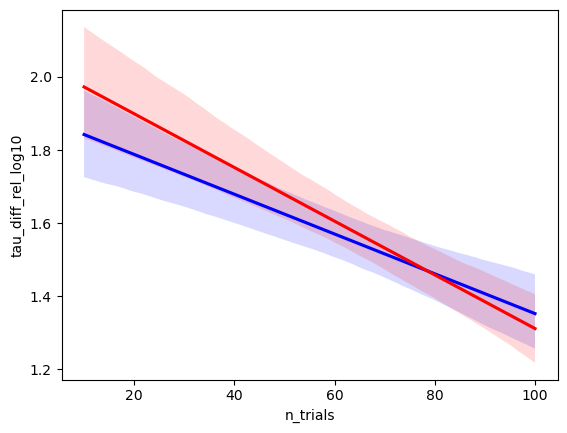

In [24]:
sttc_trial_concat_plot_df['tau_diff_rel_log10'] = np.log10(sttc_trial_concat_plot_df['tau_diff_rel'])
pearsontr_trial_avg_plot_df['tau_diff_rel_log10'] = np.log10(pearsontr_trial_avg_plot_df['tau_diff_rel'])

sns.regplot(x='n_trials', y='tau_diff_rel_log10', data=sttc_trial_concat_plot_df,
            scatter=None, color='blue')
sns.regplot(x='n_trials', y='tau_diff_rel_log10', data=pearsontr_trial_avg_plot_df,
            scatter=None, color='red')

<Axes: xlabel='trial_len_ms', ylabel='tau_diff_rel_log10'>

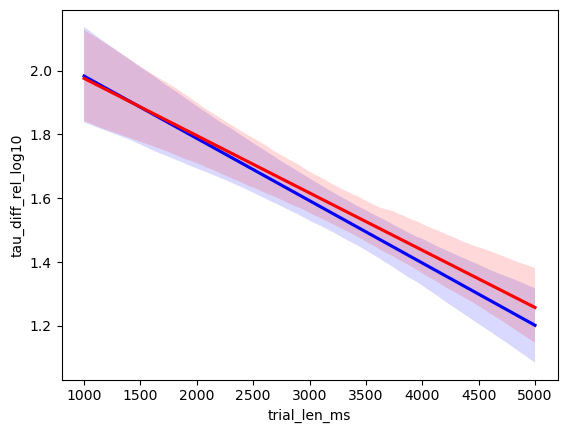

In [25]:
sns.regplot(x='trial_len_ms', y='tau_diff_rel_log10', data=sttc_trial_concat_plot_df,
            scatter=None, color='blue')
sns.regplot(x='trial_len_ms', y='tau_diff_rel_log10', data=pearsontr_trial_avg_plot_df,
            scatter=None, color='red')

In [ ]:
# check for NaNs and for a long df remove rows with NaNs (if for a unit one method failed than remove it)

rows_with_nans_pearsonr_df = pearsontr_trial_avg_plot_df[pearsontr_trial_avg_plot_df.isna().any(axis=1)]
n_rows_with_nan_pearsonr = len(rows_with_nans_pearsonr_df)
print(f'N rows with NaNs {n_rows_with_nan_pearsonr}')

rows_with_nans_isttc_concat_df = sttc_trial_concat_plot_df[sttc_trial_concat_plot_df.isna().any(axis=1)]
n_rows_with_nan_isttc_concat = len(rows_with_nans_isttc_concat_df)
print(f'N rows with NaNs {n_rows_with_nan_isttc_concat}')

# rows_with_nans_isttc_avg_df = sttc_trial_avg_plot_df[sttc_trial_avg_plot_df.isna().any(axis=1)]
# n_rows_with_nan_isttc_avg = len(rows_with_nans_isttc_avg_df)
# print(f'N rows with NaNs {n_rows_with_nan_isttc_avg}')

pearsonr_nan_unit_ids = rows_with_nans_pearsonr_df['unit_id'].values
sttc_concat_nan_unit_ids = rows_with_nans_isttc_concat_df['unit_id'].values
# sttc_avg_nan_unit_ids = rows_with_nans_isttc_avg_df['unit_id'].values

unit_ids_nan_union = set(pearsonr_nan_unit_ids).union(sttc_concat_nan_unit_ids).union(sttc_avg_nan_unit_ids)
print(f'N rows in unit_ids_nan_union {len(unit_ids_nan_union)}')

# take rows without NaNs
pearsonr_sans_nans_plot_df = pearsontr_trial_avg_plot_df[~pearsontr_trial_avg_plot_df['unit_id'].isin(unit_ids_nan_union)]
sttc_concat_sans_nans_plot_df = sttc_trial_concat_plot_df[~sttc_trial_concat_plot_df['unit_id'].isin(unit_ids_nan_union)]
sttc_avg_sans_nans_plot_df = sttc_trial_avg_plot_df[~sttc_trial_avg_plot_df['unit_id'].isin(unit_ids_nan_union)]

print(f'len pearsonr {len(pearsonr_sans_nans_plot_df)}, len sttc_concat {len(sttc_concat_sans_nans_plot_df)}, len sttc_avg {len(sttc_avg_sans_nans_plot_df)}')

In [ ]:
# check for negative R-square

rows_with_negr_pearsonr_df = pearsonr_sans_nans_plot_df.query('fit_r_squared < 0')
n_rows_with_negr_pearsonr = len(rows_with_negr_pearsonr_df)
print(f'N rows with neg R {n_rows_with_negr_pearsonr}')

rows_with_negr_isttc_concat_df = sttc_concat_sans_nans_plot_df.query('fit_r_squared < 0')
n_rows_with_negr_isttc_concat = len(rows_with_negr_isttc_concat_df)
print(f'N rows with neg R {n_rows_with_negr_isttc_concat}')

rows_with_negr_isttc_avg_df = sttc_avg_sans_nans_plot_df.query('fit_r_squared < 0')
n_rows_with_negr_isttc_avg = len(rows_with_negr_isttc_avg_df)
print(f'N rows with neg R {n_rows_with_negr_isttc_avg}')

pearsonr_negr_unit_ids = rows_with_negr_pearsonr_df['unit_id'].values
isttc_concat_negr_unit_ids = rows_with_negr_isttc_concat_df['unit_id'].values
isttc_avg_negr_unit_ids = rows_with_negr_isttc_avg_df['unit_id'].values

unit_ids_negr_union = set(pearsonr_negr_unit_ids).union(isttc_concat_negr_unit_ids).union(isttc_avg_negr_unit_ids)
print(f'N rows in unit_ids_negr_union {len(unit_ids_negr_union)}, : {unit_ids_negr_union}')

pearsonr_sans_negr_plot_df = pearsonr_sans_nans_plot_df[~pearsonr_sans_nans_plot_df['unit_id'].isin(unit_ids_negr_union)].copy()
sttc_concat_sans_negr_plot_df = sttc_concat_sans_nans_plot_df[~sttc_concat_sans_nans_plot_df['unit_id'].isin(unit_ids_negr_union)].copy()
sttc_avg_sans_negr_plot_df = sttc_avg_sans_nans_plot_df[~sttc_avg_sans_nans_plot_df['unit_id'].isin(unit_ids_negr_union)].copy()

pearsonr_sans_negr_plot_df['tau_diff_rel_log10'] = np.log10(pearsonr_sans_negr_plot_df['tau_diff_rel'])
sttc_concat_sans_negr_plot_df['tau_diff_rel_log10'] = np.log10(sttc_concat_sans_negr_plot_df['tau_diff_rel'])
sttc_avg_sans_negr_plot_df['tau_diff_rel_log10'] = np.log10(sttc_avg_sans_negr_plot_df['tau_diff_rel'])

print(f'len pearsonr {len(pearsonr_sans_negr_plot_df)}, len sttc_concat {len(sttc_concat_sans_negr_plot_df)}, len sttc_avg {len(sttc_avg_sans_negr_plot_df)}')

In [ ]:
tau_plot_long_df = pd.concat([pearsonr_sans_negr_plot_df, 
                              sttc_concat_sans_negr_plot_df, 
                              sttc_avg_sans_negr_plot_df])
tau_plot_long_df['log_tau_ms'] = np.log10(tau_plot_long_df['tau_ms'])
tau_plot_long_df.reset_index(inplace=True, drop=True)

print(f'len tau_plot_long_df {len(tau_plot_long_df)}')

tau_plot_long_df.head(3)

### Export for stats

In [ ]:
tau_plot_long_df.to_csv(results_folder + 'tau_plot_long_df.csv')

### Plots

In [ ]:
color_pearson_trail_avg = '#6A5ACD' 
color_sttc_trail_avg =  '#FF7F50' 
color_sttc_trail_concat = '#C71585' 

In [ ]:
# tau_plot_wide_df = acf_full_plot_df.merge(isttc_full_plot_df, suffixes=('_acf', '_isttc'), 
#                                           on=['unit_id','fr', 'alpha', 'tau_ms_true', 'duration_ms', 'duration_s', 'dur_interval'], 
#                                           how='left')
# tau_plot_wide_df.reset_index(inplace=True, drop=True)

# print(f'len tau_plot_wide_df {len(tau_plot_wide_df)}')

# tau_plot_wide_df.columns

In [ ]:
# just to check, I plot the same as predicted values from the model
fig, axes = plt.subplots(1,2, figsize=(10, 3), sharey=False)

sns.regplot(x='n_trials', y='tau_diff_rel_log10', data=tau_plot_long_df.query('method == "pearsonr_trial_avg"'),
            scatter=None, ax=axes[0], 
            label='pearsonr', color=color_pearson_trail_avg)
sns.regplot(x='n_trials', y='tau_diff_rel_log10', data=tau_plot_long_df.query('method == "sttc_trial_concat"'),
            scatter=None, ax=axes[0], 
            label='isttc_concat', color=color_sttc_trail_concat)
sns.regplot(x='n_trials', y='tau_diff_rel_log10', data=tau_plot_long_df.query('method == "sttc_trial_avg"'),
            scatter=None, ax=axes[0], 
            label='isttc_avg', color=color_sttc_trail_avg)
axes[0].legend(frameon=False)
axes[0].set_xlabel('Number of trials')

sns.regplot(x='trial_len_ms', y='tau_diff_rel_log10', data=tau_plot_long_df.query('method == "pearsonr_trial_avg"'),
            scatter=None, ax=axes[1], 
            label='pearsonr', color=color_pearson_trail_avg)
sns.regplot(x='trial_len_ms', y='tau_diff_rel_log10', data=tau_plot_long_df.query('method == "sttc_trial_concat"'),
            scatter=None, ax=axes[1], 
            label='isttc_concat', color=color_sttc_trail_concat)
sns.regplot(x='trial_len_ms', y='tau_diff_rel_log10', data=tau_plot_long_df.query('method == "sttc_trial_avg"'),
            scatter=None, ax=axes[1], 
            label='isttc_avg', color=color_sttc_trail_avg)
axes[1].legend(frameon=False)
axes[1].set_xlabel('Trial length ()')

# for ax in axes.flat:
#     ax.set_ylabel('Log10 diff(IT, \nground truth) (ms)')

sns.despine()

In [ ]:
tau_2methods_error_df

In [ ]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    """
    Return a new colormap based on cmap but only sampling its colors
    between minval and maxval (both in [0,1]).
    """
    new_colors = cmap(np.linspace(minval, maxval, n))
    new_cmap = LinearSegmentedColormap.from_list(
        f"{cmap.name}_trunc_{minval:.2f}_{maxval:.2f}",
        new_colors
    )
    return new_cmap

trunc_magma = truncate_colormap(plt.cm.magma, minval=0.15, maxval=1)


fig, axes = plt.subplots(1,3, figsize=(10,2.5))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

#norm = TwoSlopeNorm(vcenter=0)

hb0 = axes[0].hexbin(
    x=pearsonr_sans_negr_plot_df['n_trials'], y=pearsonr_sans_negr_plot_df['trial_len_ms'],
    C=pearsonr_sans_negr_plot_df['tau_diff_rel'],
    reduce_C_function=np.median,   
    gridsize=5,                
    cmap=trunc_magma,
    #norm = norm,
    mincnt=1                    
)

hb1 = axes[1].hexbin(
    x=sttc_avg_sans_negr_plot_df['n_trials'], y=sttc_avg_sans_negr_plot_df['trial_len_ms'],
    C=sttc_avg_sans_negr_plot_df['tau_diff_rel'],
    reduce_C_function=np.median,   
    gridsize=5,                
    cmap=trunc_magma,
    mincnt=1                    
)

hb2 = axes[2].hexbin(
    x=sttc_concat_sans_negr_plot_df['n_trials'], y=sttc_concat_sans_negr_plot_df['trial_len_ms'],
    C=sttc_concat_sans_negr_plot_df['tau_diff_rel'],
    reduce_C_function=np.median,   
    gridsize=5,                
    cmap=trunc_magma,
    #norm = norm,
    mincnt=1                    
)

vmin = np.floor(np.min([hb0.get_array().min(), hb1.get_array().min(), hb2.get_array().min()]))
vmax = np.ceil(np.max([hb0.get_array().max(), hb1.get_array().max(), hb2.get_array().max()]))
print(vmin, vmax)

hb0.set_clim(vmin, vmax)
hb1.set_clim(vmin, vmax)
hb2.set_clim(vmin, vmax)

fig.colorbar(hb0, ax=axes[0], shrink=1)
fig.colorbar(hb1, ax=axes[1], shrink=1)
fig.colorbar(hb2, ax=axes[2], shrink=1)

axes[0].set_title('Pearsonr avg')
axes[1].set_title('STTC avg')
axes[2].set_title('STTC concat')

fig.suptitle('Relative error (abs(tau - tau_true)/tau_true * 100)', y=1.05)

for ax in axes.flat:
    sns.despine(ax=ax)
    ax.set_ylabel('Trial length (ma)')
    ax.set_xlabel('N trials')
    ax.set_ylim([1000, 5000])
    ax.set_yticks(np.linspace(1000, 5000, 5))
    ax.set_xlim([10, 100])
    ax.set_xticks(np.linspace(20, 100, 5))



In [ ]:
fig, axes = plt.subplots(1,2, figsize=(7,2.5))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

norm = TwoSlopeNorm(vcenter=0)

hb0 = axes[0].hexbin(
    x=pearsonr_sans_negr_plot_df['n_trials'], y=pearsonr_sans_negr_plot_df['trial_len_ms'],
    C=sttc_concat_sans_negr_plot_df['tau_diff_rel'] - pearsonr_sans_negr_plot_df['tau_diff_rel'],
    reduce_C_function=np.median,   
    gridsize=5,                
    cmap='coolwarm',
    norm = norm,
    mincnt=1                    
)

hb1 = axes[1].hexbin(
    x=sttc_avg_sans_negr_plot_df['n_trials'], y=sttc_avg_sans_negr_plot_df['trial_len_ms'],
    C=sttc_concat_sans_negr_plot_df['tau_diff_rel'] - sttc_avg_sans_negr_plot_df['tau_diff_rel'],
    reduce_C_function=np.median,   
    gridsize=5,                
    cmap='coolwarm',
    norm = norm,
    mincnt=1                    
)

vmin = np.floor(np.min([hb0.get_array().min(), hb1.get_array().min()]))
vmax = np.ceil(np.max([hb0.get_array().max(), hb1.get_array().max()]))
print(vmin, vmax)

hb0.set_clim(vmin, vmax)
hb1.set_clim(vmin, vmax)


fig.colorbar(hb0, ax=axes[0], shrink=1)
fig.colorbar(hb1, ax=axes[1], shrink=1)

# axes[0].set_title('Pearsonr avg')
# axes[1].set_title('STTC avg')
# axes[2].set_title('STTC concat')

fig.suptitle('Relative error (abs(tau - tau_true)/tau_true * 100)', y=1.05)

for ax in axes.flat:
    sns.despine(ax=ax)
    ax.set_ylabel('Trial length (ma)')
    ax.set_xlabel('N trials')
    ax.set_ylim([1000, 5000])
    ax.set_yticks(np.linspace(1000, 5000, 5))
    ax.set_xlim([10, 100])
    ax.set_xticks(np.linspace(20, 100, 5))

